# Model Development

Now we are goin to contrast 4 models:

- XGboost
- Logistic Regression
- Catboost
- LightGBM

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import shap
import joblib

# Project utilities (expected in repo)
from functions import (
    DataProfile,
    FeatureEngineering,
    StabilityMetrics,
    WOEAnalysis,
    ModelEvaluation,
    BusinessAnalysis,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Data Loading and preprocessing

In [11]:
X_train = pd.read_parquet("data/eda/X_train.parquet")
X_valid = pd.read_parquet("data/eda/X_valid.parquet")
X_test = pd.read_parquet("data/eda/X_test.parquet")

y_train = np.load("data/eda/y_train.npy")
y_valid = np.load("data/eda/y_valid.npy")
y_test = np.load("data/eda/y_test.npy")

print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test:  {X_test.shape}")
print(f"\nDefault rates:")
print(f"Train: {y_train.mean():.2%}")
print(f"Valid: {y_valid.mean():.2%}")
print(f"Test:  {y_test.mean():.2%}")

Train: (1257997, 21)
Valid: (462928, 21)
Test:  (190890, 21)

Default rates:
Train: 17.89%
Valid: 10.20%
Test:  7.11%


In [12]:
X_train.head()

,acc_open_past_24mths,avg_cur_bal_bin,bc_open_to_buy,dti,emp_length_yrs,fico_mid,home_ownership,inq_last_6mths_bin,install_to_income_bin,loan_to_income_bin,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_actv_rev_tl,num_tl_op_past_12m,open_rv_24m,total_bc_limit,verification_status
0,7.0,0_001_11000_0,7144.0,27.74,10.0,717.0,OWN,0_001_1_0,0_1_inf,0_22_0_3,255.0,1.0,1.0,0.0,14.0,8.0,6.0,3.0,4.0,15500.0,Source Verified
1,8.0,15000_0_25000_0,81313.0,12.35,10.0,717.0,MORTGAGE,0_001_1_0,0_07_0_1,0_16_0_22,144.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,7.0,124200.0,Source Verified
2,4.0,15000_0_25000_0,51211.0,31.11,9.0,767.0,MORTGAGE,0_001_1_0,0_07_0_1,0_3_inf,185.0,26.0,3.0,4.0,26.0,11.0,4.0,2.0,0.0,64600.0,Verified
3,0.0,0_001_11000_0,336.0,15.94,5.0,702.0,RENT,0_001_1_0,0_07_0_1,0_16_0_22,207.0,32.0,32.0,0.0,206.0,999.0,11.0,0.0,0.0,3700.0,Not Verified
4,5.0,0_001_11000_0,11049.0,12.27,10.0,712.0,RENT,0_001_1_0,0_07_0_1,0_16_0_22,145.0,11.0,11.0,0.0,11.0,1.0,8.0,1.0,5.0,18000.0,Source Verified


In [13]:
FINAL_FEATURE_SET =  ['acc_open_past_24mths', 'avg_cur_bal_bin', 'bc_open_to_buy', 'dti', 'emp_length_yrs', 'fico_mid', 'home_ownership', 'inq_last_6mths_bin', 'install_to_income_bin', 'loan_to_income_bin', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_rev_tl', 'num_tl_op_past_12m', 'open_rv_24m', 'total_bc_limit', 'verification_status']

In [14]:
cat_features = [
    "home_ownership",
    "inq_last_6mths_bin",
    "install_to_income_bin",
    "loan_to_income_bin",
    "verification_status",
    "avg_cur_bal_bin",
]
cat_features = [f for f in cat_features if f in FINAL_FEATURE_SET]
num_features = [f for f in FINAL_FEATURE_SET if f not in cat_features]

print(f"Categorical features ({len(cat_features)}): {cat_features}")
print(f"Numeric features ({len(num_features)}): {len(num_features)}")

numeric_transformer = SimpleImputer(strategy="median")
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop",
)

preprocessor.fit(X_train)
X_train_prep = preprocessor.transform(X_train)
X_valid_prep = preprocessor.transform(X_valid)
X_test_prep = preprocessor.transform(X_test)

feature_names = num_features.copy()
if cat_features:
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    feature_names += list(ohe.get_feature_names_out(cat_features))

print(f"\nTotal features after preprocessing: {len(feature_names)}")

Categorical features (6): ['home_ownership', 'inq_last_6mths_bin', 'install_to_income_bin', 'loan_to_income_bin', 'verification_status', 'avg_cur_bal_bin']
Numeric features (15): 15

Total features after preprocessing: 45


### 5.1 XGBoost Model

In [15]:
n_positive = (y_train == 1).sum()
n_negative = (y_train == 0).sum()
scale_pos_weight = n_negative / n_positive

print(f"Class imbalance ratio: {scale_pos_weight:.2f}")

monotone_constraints = {
    "dti": +1,
    "inq_last_6mths": +1,
    "percent_bc_gt_75": +1,
    "num_tl_op_past_12m": +1,
    "open_rv_12m": +1,
    "open_rv_24m": +1,
    "fico_mid": -1,
    "bc_open_to_buy": -1,
    "avg_cur_bal": -1,
    "total_bc_limit": -1,
    "mths_since_recent_inq": -1,
    "mths_since_rcnt_il": -1,
    "mths_since_recent_bc": -1,
}

mono_vec = [monotone_constraints.get(f, 0) for f in num_features]
mono_vec += [0] * (len(feature_names) - len(num_features))
monotone_str = "(" + ",".join(str(int(v)) for v in mono_vec) + ")"

xgb_params = {
    "eta": 0.03,
    "max_depth": 4,
    "min_child_weight": 20,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "alpha": 5.0,
    "lambda": 10.0,
    "tree_method": "hist",
    "objective": "binary:logistic",
    "scale_pos_weight": scale_pos_weight,
    "eval_metric": ["auc", "aucpr", "logloss"],
    "monotone_constraints": monotone_str,
    "random_state": RANDOM_STATE,
}

dtrain = xgb.DMatrix(X_train_prep, label=y_train, feature_names=feature_names)
dvalid = xgb.DMatrix(X_valid_prep, label=y_valid, feature_names=feature_names)
dtest = xgb.DMatrix(X_test_prep, label=y_test, feature_names=feature_names)

print("\nTraining XGBoost model...")
evals = [(dtrain, "train"), (dvalid, "valid")]
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=evals,
    early_stopping_rounds=200,
    verbose_eval=100,
)

print(f"\nBest iteration: {xgb_model.best_iteration}")

Class imbalance ratio: 4.59

Training XGBoost model...
[0]	train-auc:0.62924	train-aucpr:0.26262	train-logloss:0.69156	valid-auc:0.61344	valid-aucpr:0.14868	valid-logloss:0.69067
[100]	train-auc:0.67535	train-aucpr:0.30333	train-logloss:0.64788	valid-auc:0.66196	valid-aucpr:0.17352	valid-logloss:0.61918
[200]	train-auc:0.68039	train-aucpr:0.30850	train-logloss:0.64196	valid-auc:0.66634	valid-aucpr:0.17623	valid-logloss:0.60933
[300]	train-auc:0.68246	train-aucpr:0.31078	train-logloss:0.63997	valid-auc:0.66776	valid-aucpr:0.17741	valid-logloss:0.60613
[400]	train-auc:0.68407	train-aucpr:0.31252	train-logloss:0.63929	valid-auc:0.66863	valid-aucpr:0.17819	valid-logloss:0.60589
[500]	train-auc:0.68510	train-aucpr:0.31368	train-logloss:0.63870	valid-auc:0.66921	valid-aucpr:0.17871	valid-logloss:0.60584
[600]	train-auc:0.68585	train-aucpr:0.31448	train-logloss:0.63827	valid-auc:0.66941	valid-aucpr:0.17892	valid-logloss:0.60584
[700]	train-auc:0.68642	train-aucpr:0.31515	train-logloss:0.63787

In [ ]:
y_train_pred_raw = xgb_model.predict(dtrain, iteration_range=(0, xgb_model.best_iteration + 1))
y_valid_pred_raw = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
y_test_pred_raw = xgb_model.predict(dtest, iteration_range=(0, xgb_model.best_iteration + 1))

print("Calibrating predictions...")
calibrator = IsotonicRegression(out_of_bounds="clip")
calibrator.fit(y_valid_pred_raw, y_valid)

y_train_pred_xgb = calibrator.predict(y_train_pred_raw)
y_valid_pred_xgb = calibrator.predict(y_valid_pred_raw)
y_test_pred_xgb = calibrator.predict(y_test_pred_raw)

Calibrating predictions...
XGBoost training complete


### 5.2 LightGBM Model

In [ ]:
print("\nTraining LightGBM model...")

lgb_params = {
    "objective": "binary",
    "metric": ["auc", "binary_logloss"],
    "boosting_type": "gbdt",
    "learning_rate": 0.03,
    "num_leaves": 31,
    "max_depth": 4,
    "min_child_samples": 20,
    "subsample": 0.8,
    "subsample_freq": 1,
    "colsample_bytree": 0.8,
    "reg_alpha": 5.0,
    "reg_lambda": 10.0,
    "scale_pos_weight": scale_pos_weight,
    "verbose": -1,
    "random_state": RANDOM_STATE,
}

lgb_train = lgb.Dataset(
    X_train_prep, label=y_train, feature_name=feature_names, categorical_feature="auto"
)
lgb_valid = lgb.Dataset(
    X_valid_prep, label=y_valid, feature_name=feature_names, categorical_feature="auto", reference=lgb_train
)

lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train,
    num_boost_round=5000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train", "valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=200, verbose=True),
        lgb.log_evaluation(period=100),
    ],
)

print(f"\nBest iteration: {lgb_model.best_iteration}")

y_train_pred_lgb_raw = lgb_model.predict(X_train_prep, num_iteration=lgb_model.best_iteration)
y_valid_pred_lgb_raw = lgb_model.predict(X_valid_prep, num_iteration=lgb_model.best_iteration)
y_test_pred_lgb_raw = lgb_model.predict(X_test_prep, num_iteration=lgb_model.best_iteration)

print("Calibrating LightGBM predictions...")
calibrator_lgb = IsotonicRegression(out_of_bounds="clip")
calibrator_lgb.fit(y_valid_pred_lgb_raw, y_valid)

y_train_pred_lgb = calibrator_lgb.predict(y_train_pred_lgb_raw)
y_valid_pred_lgb = calibrator_lgb.predict(y_valid_pred_lgb_raw)
y_test_pred_lgb = calibrator_lgb.predict(y_test_pred_lgb_raw)


Training LightGBM model...
Training until validation scores don't improve for 200 rounds
[100]	train's auc: 0.676897	train's binary_logloss: 0.628128	valid's auc: 0.663806	valid's binary_logloss: 0.596237
[200]	train's auc: 0.681341	train's binary_logloss: 0.640878	valid's auc: 0.667853	valid's binary_logloss: 0.607842
Early stopping, best iteration is:
[1]	train's auc: 0.635698	train's binary_logloss: 0.468288	valid's auc: 0.624213	valid's binary_logloss: 0.356247

Best iteration: 1
Calibrating LightGBM predictions...
LightGBM training complete


### 5.3 CatBoost Model

In [18]:
print("\nTraining CatBoost model...")

cat_feature_indices = [FINAL_FEATURE_SET.index(f) for f in cat_features if f in FINAL_FEATURE_SET]

cat_train = Pool(data=X_train[FINAL_FEATURE_SET], label=y_train, cat_features=cat_feature_indices)
cat_valid = Pool(data=X_valid[FINAL_FEATURE_SET], label=y_valid, cat_features=cat_feature_indices)
cat_test = Pool(data=X_test[FINAL_FEATURE_SET], label=y_test, cat_features=cat_feature_indices)

catboost_params = {
    "iterations": 5000,
    "learning_rate": 0.03,
    "depth": 4,
    "l2_leaf_reg": 10.0,
    "min_data_in_leaf": 20,
    "subsample": 0.8,
    "random_strength": 1.0,
    "bagging_temperature": 1.0,
    "scale_pos_weight": scale_pos_weight,
    "eval_metric": "AUC",
    "random_seed": RANDOM_STATE,
    "verbose": 100,
    "early_stopping_rounds": 200,
    "task_type": "CPU",
    "use_best_model": True,
}

cat_model = CatBoostClassifier(**catboost_params)
cat_model.fit(cat_train, eval_set=cat_valid, verbose=100, plot=False)

print(f"\nBest iteration: {cat_model.get_best_iteration()}")

y_train_pred_cat_raw = cat_model.predict_proba(cat_train)[:, 1]
y_valid_pred_cat_raw = cat_model.predict_proba(cat_valid)[:, 1]
y_test_pred_cat_raw = cat_model.predict_proba(cat_test)[:, 1]

print("Calibrating CatBoost predictions...")
calibrator_cat = IsotonicRegression(out_of_bounds="clip")
calibrator_cat.fit(y_valid_pred_cat_raw, y_valid)

y_train_pred_cat = calibrator_cat.predict(y_train_pred_cat_raw)
y_valid_pred_cat = calibrator_cat.predict(y_valid_pred_cat_raw)
y_test_pred_cat = calibrator_cat.predict(y_test_pred_cat_raw)


Training CatBoost model...
0:	test: 0.6200775	best: 0.6200775 (0)	total: 349ms	remaining: 29m 4s
100:	test: 0.6605609	best: 0.6605609 (100)	total: 18.1s	remaining: 14m 36s
200:	test: 0.6652283	best: 0.6652283 (200)	total: 37s	remaining: 14m 43s
300:	test: 0.6674833	best: 0.6674833 (300)	total: 56.4s	remaining: 14m 41s
400:	test: 0.6688979	best: 0.6688979 (400)	total: 1m 16s	remaining: 14m 34s
500:	test: 0.6700351	best: 0.6700351 (500)	total: 1m 36s	remaining: 14m 24s
600:	test: 0.6709967	best: 0.6710093 (598)	total: 1m 56s	remaining: 14m 10s
700:	test: 0.6716577	best: 0.6716577 (700)	total: 2m 16s	remaining: 13m 57s
800:	test: 0.6722272	best: 0.6722272 (800)	total: 2m 36s	remaining: 13m 41s
900:	test: 0.6725490	best: 0.6725490 (900)	total: 2m 57s	remaining: 13m 25s
1000:	test: 0.6728454	best: 0.6728454 (1000)	total: 3m 17s	remaining: 13m 8s
1100:	test: 0.6730852	best: 0.6730880 (1098)	total: 3m 37s	remaining: 12m 49s
1200:	test: 0.6732803	best: 0.6732803 (1200)	total: 3m 57s	remaining

### 5.4 Logistic Regression

In [19]:
print("Training Logistic Regression...")

lr_model = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=5000,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

lr_model.fit(X_train_prep, y_train)

y_train_pred_lr_raw = lr_model.predict_proba(X_train_prep)[:, 1]
y_valid_pred_lr_raw = lr_model.predict_proba(X_valid_prep)[:, 1]
y_test_pred_lr_raw = lr_model.predict_proba(X_test_prep)[:, 1]

calibrator_lr = IsotonicRegression(out_of_bounds="clip")
calibrator_lr.fit(y_valid_pred_lr_raw, y_valid)

y_train_pred_lr = calibrator_lr.predict(y_train_pred_lr_raw)
y_valid_pred_lr = calibrator_lr.predict(y_valid_pred_lr_raw)
y_test_pred_lr = calibrator_lr.predict(y_test_pred_lr_raw)

Training Logistic Regression...


## 6. Model Evaluation & Interpretation

# 6.1 Comparison by Main Metrics (K-S, AUC)

In [20]:
evaluator = ModelEvaluation()
stability = StabilityMetrics()

# XGBoost evaluation
xgb_metrics = {}
xgb_metrics.update(evaluator.comprehensive_metrics(y_train, y_train_pred_xgb, "Train"))
xgb_metrics.update(evaluator.comprehensive_metrics(y_valid, y_valid_pred_xgb, "Valid"))
xgb_metrics.update(evaluator.comprehensive_metrics(y_test, y_test_pred_xgb, "Test"))

xgb_results = pd.DataFrame([xgb_metrics]).T
xgb_results.columns = ["XGBoost"]

# LightGBM evaluation
lgb_metrics = {}
lgb_metrics.update(evaluator.comprehensive_metrics(y_train, y_train_pred_lgb, "Train"))
lgb_metrics.update(evaluator.comprehensive_metrics(y_valid, y_valid_pred_lgb, "Valid"))
lgb_metrics.update(evaluator.comprehensive_metrics(y_test, y_test_pred_lgb, "Test"))

lgb_results = pd.DataFrame([lgb_metrics]).T
lgb_results.columns = ["LightGBM"]

# CatBoost evaluation
cat_metrics = {}
cat_metrics.update(evaluator.comprehensive_metrics(y_train, y_train_pred_cat, "Train"))
cat_metrics.update(evaluator.comprehensive_metrics(y_valid, y_valid_pred_cat, "Valid"))
cat_metrics.update(evaluator.comprehensive_metrics(y_test, y_test_pred_cat, "Test"))

cat_results = pd.DataFrame([cat_metrics]).T
cat_results.columns = ["CatBoost"]

# Logistic Regression evaluation
lr_metrics = {}
lr_metrics.update(evaluator.comprehensive_metrics(y_train, y_train_pred_lr, "Train"))
lr_metrics.update(evaluator.comprehensive_metrics(y_valid, y_valid_pred_lr, "Valid"))
lr_metrics.update(evaluator.comprehensive_metrics(y_test, y_test_pred_lr, "Test"))

lr_results = pd.DataFrame([lr_metrics]).T
lr_results.columns = ["Logistic Regression"]

In [21]:
comparison = pd.concat([xgb_results, lgb_results, cat_results, lr_results], axis=1)
print("\n" + "=" * 50)
print("Model Comparison")
print("=" * 50)
display(comparison)


Model Comparison


,XGBoost,LightGBM,CatBoost,Logistic Regression
AUC_Train,0.685284,0.635351,0.693324,0.658895
PR_AUC_Train,0.308897,0.255325,0.318297,0.281129
KS_Train,0.266627,0.194608,0.278523,0.231664
AUC_Valid,0.669735,0.624548,0.675298,0.641313
PR_AUC_Valid,0.177156,0.147766,0.182991,0.158001
KS_Valid,0.244618,0.184236,0.252051,0.205838
AUC_Test,0.630938,0.585333,0.639732,0.603520
PR_AUC_Test,0.111410,0.093485,0.115403,0.101291
KS_Test,0.194194,0.128243,0.203726,0.154472


### 6.2 K-S Curve Analysis

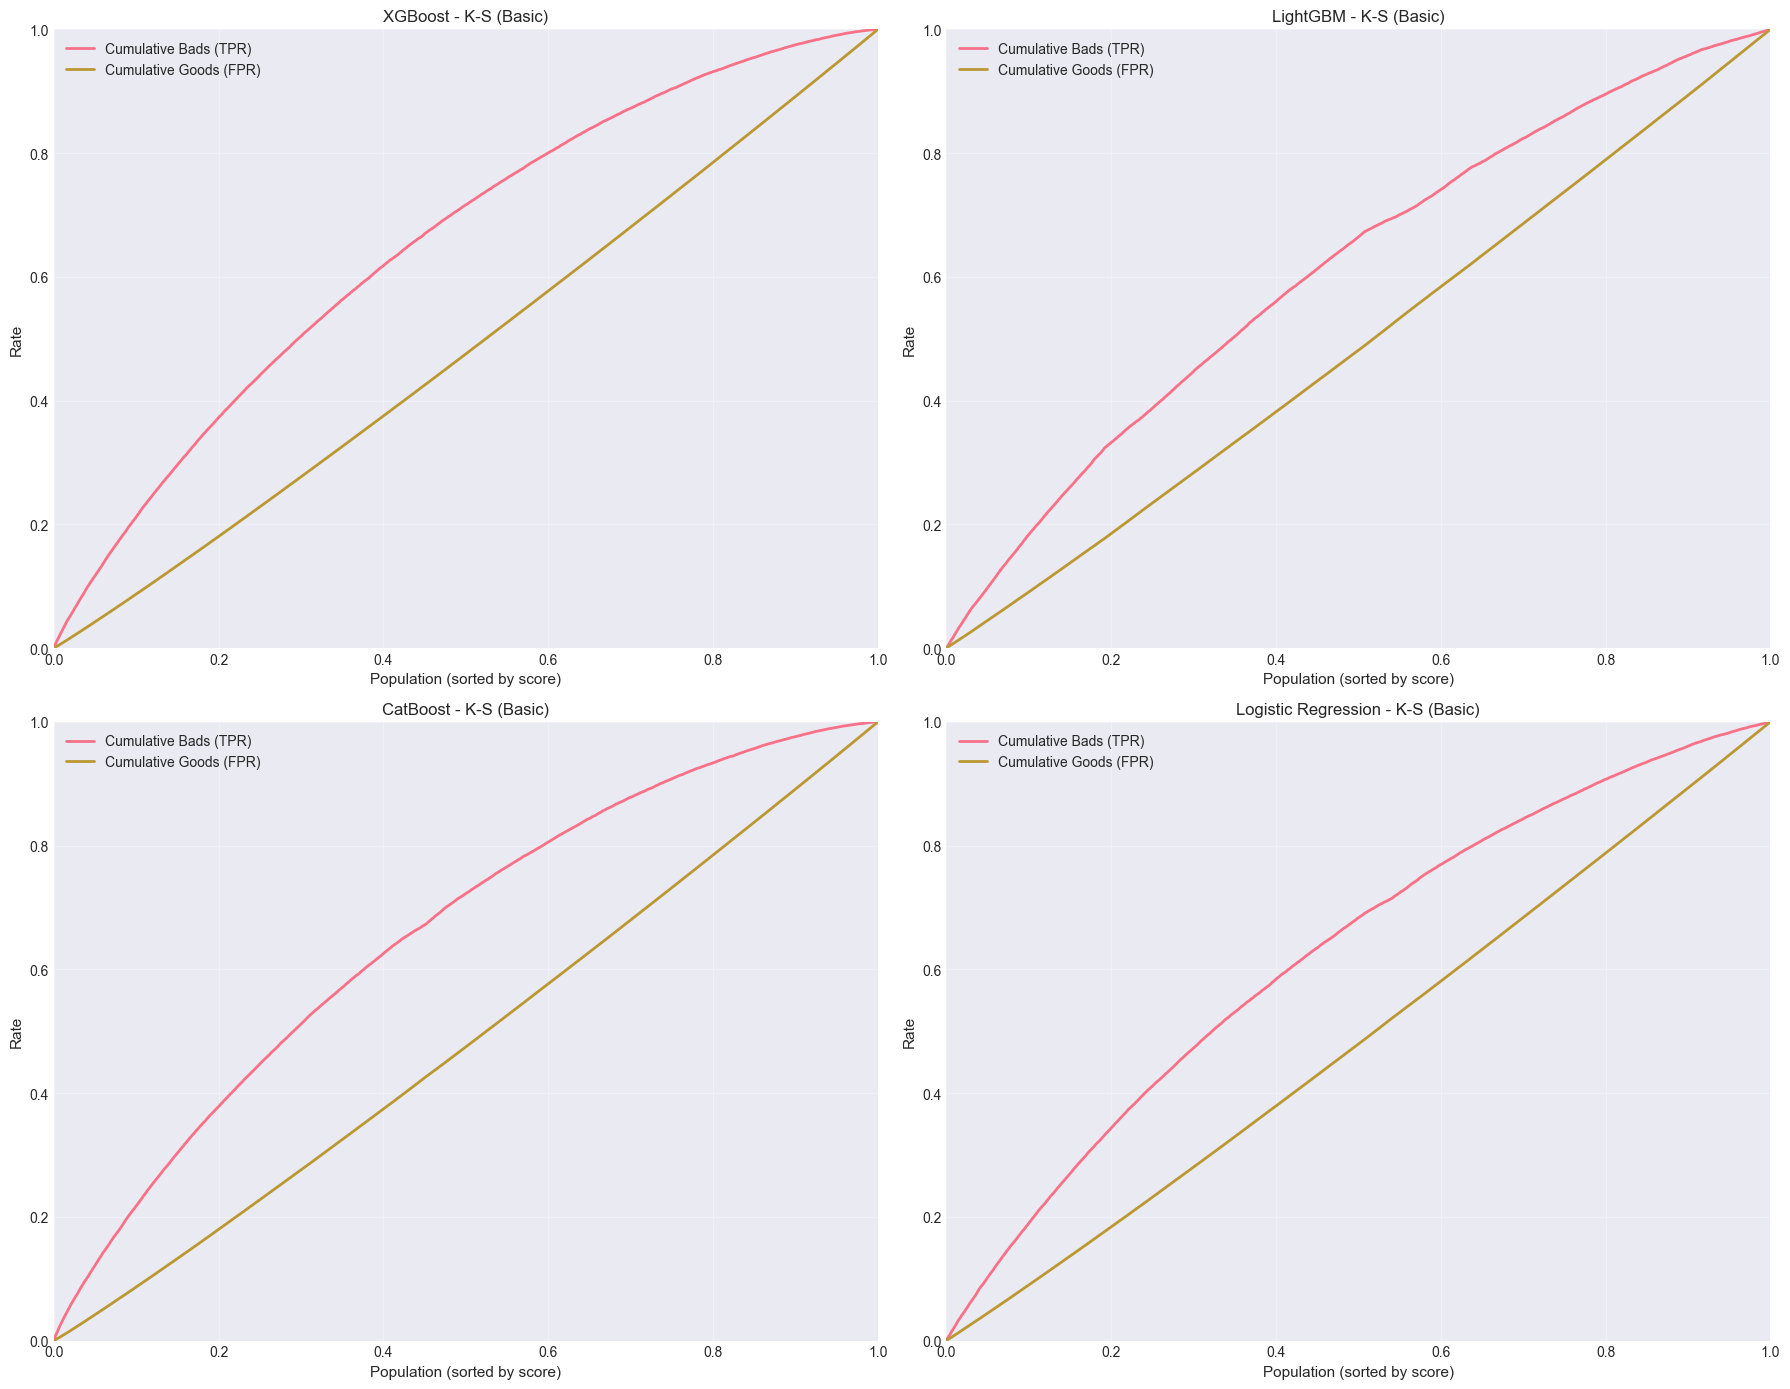


K-S Statistics Summary (Validation Set):


,Model,K-S Statistic,K-S Threshold,TPR at K-S,FPR at K-S,Capture Rate (TPR - FPR)
2,CatBoost,0.2526,0.1044,0.6495,0.3974,0.2521
0,XGBoost,0.2448,0.1037,0.6611,0.4165,0.2446
3,Logistic Regression,0.2064,0.1021,0.6418,0.4360,0.2058
1,LightGBM,0.1843,0.1060,0.6736,0.4894,0.1842


In [22]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

models_ks = [
    ("XGBoost", y_valid_pred_xgb),
    ("LightGBM", y_valid_pred_lgb),
    ("CatBoost", y_valid_pred_cat),
    ("Logistic Regression", y_valid_pred_lr),
]

ks_results = []

for idx, (model_name, y_pred) in enumerate(models_ks):
    ks_stat, ks_threshold = evaluator.plot_ks_curve(y_valid, y_pred, model_name, ax=axes[idx])
    fpr, tpr, _ = roc_curve(y_valid, y_pred)
    ks_idx = np.argmax(tpr - fpr)
    ks_results.append(
        {
            "Model": model_name,
            "K-S Statistic": ks_stat,
            "K-S Threshold": ks_threshold,
            "TPR at K-S": tpr[ks_idx],
            "FPR at K-S": fpr[ks_idx],
        }
    )

plt.tight_layout()
plt.show()

ks_summary = pd.DataFrame(ks_results)
ks_summary["Capture Rate (TPR - FPR)"] = ks_summary["TPR at K-S"] - ks_summary["FPR at K-S"]
ks_summary = ks_summary.sort_values("K-S Statistic", ascending=False)

print("\nK-S Statistics Summary (Validation Set):")
print("=" * 60)
display(ks_summary.style.format(
        {
            "K-S Statistic": "{:.4f}",
            "K-S Threshold": "{:.4f}",
            "TPR at K-S": "{:.4f}",
            "FPR at K-S": "{:.4f}",
            "Capture Rate (TPR - FPR)": "{:.4f}",
        }
    ).background_gradient(subset=["K-S Statistic"], cmap="RdYlGn"))

### 6.3 ROC Curves Comparison

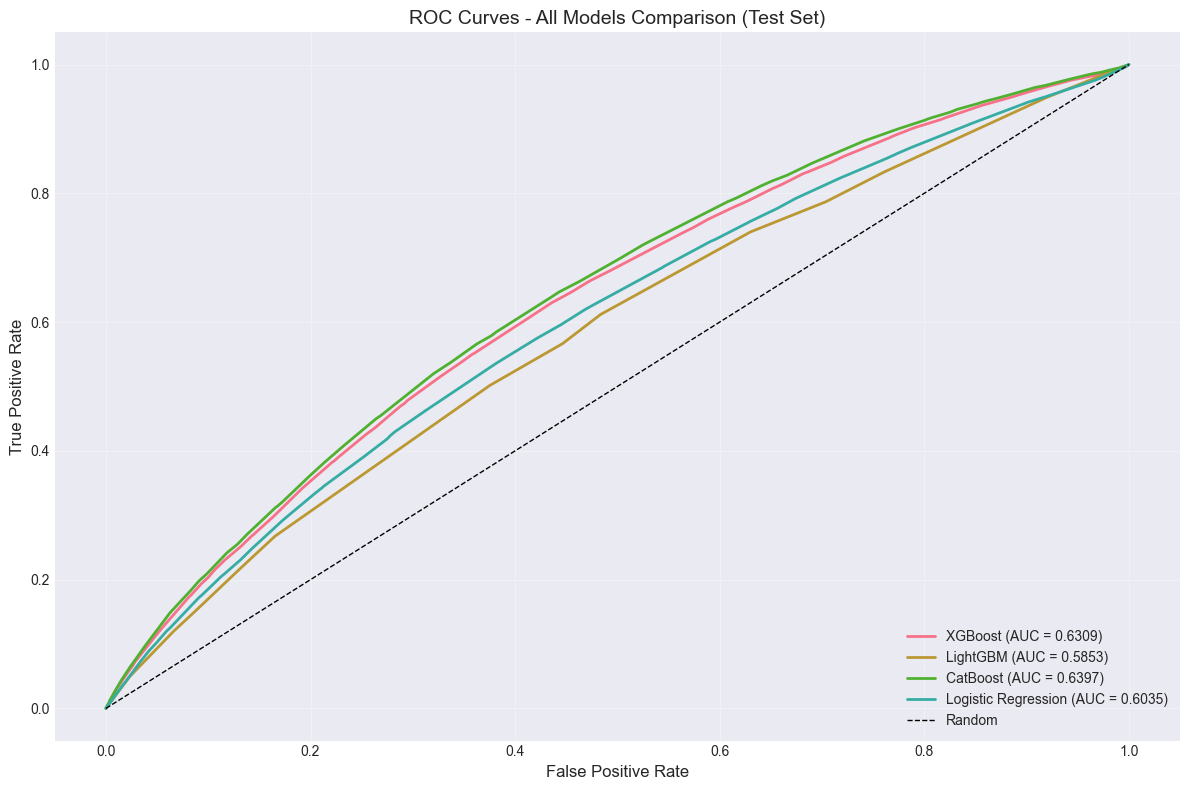

In [23]:
plt.figure(figsize=(12, 8))

models_to_plot = [
    ("XGBoost", y_test_pred_xgb),
    ("LightGBM", y_test_pred_lgb),
    ("CatBoost", y_test_pred_cat),
    ("Logistic Regression", y_test_pred_lr),
]

for name, y_pred in models_to_plot:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC = {auc_score:.4f})")

plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves - All Models Comparison (Test Set)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.4 Shap Analysis

In [24]:
N_SAMPLE = min(5000, X_valid_prep.shape[0])
sample_idx = np.random.choice(X_valid_prep.shape[0], N_SAMPLE, replace=False)
X_shap = X_valid_prep[sample_idx]

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap)

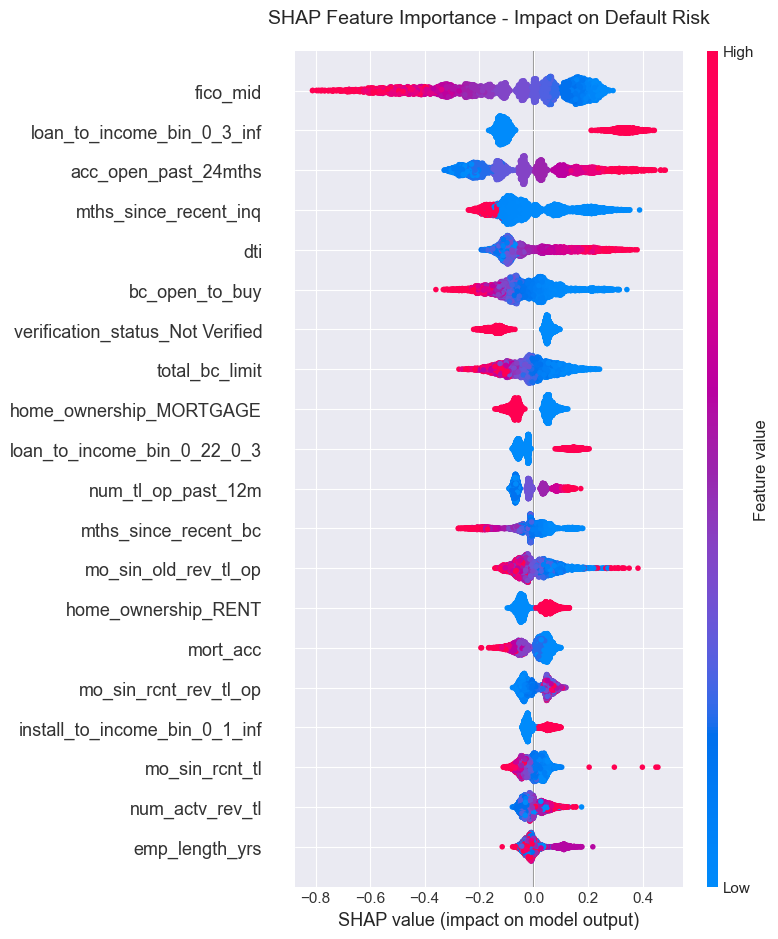

In [25]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=False, max_display=20)
plt.title("SHAP Feature Importance - Impact on Default Risk", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

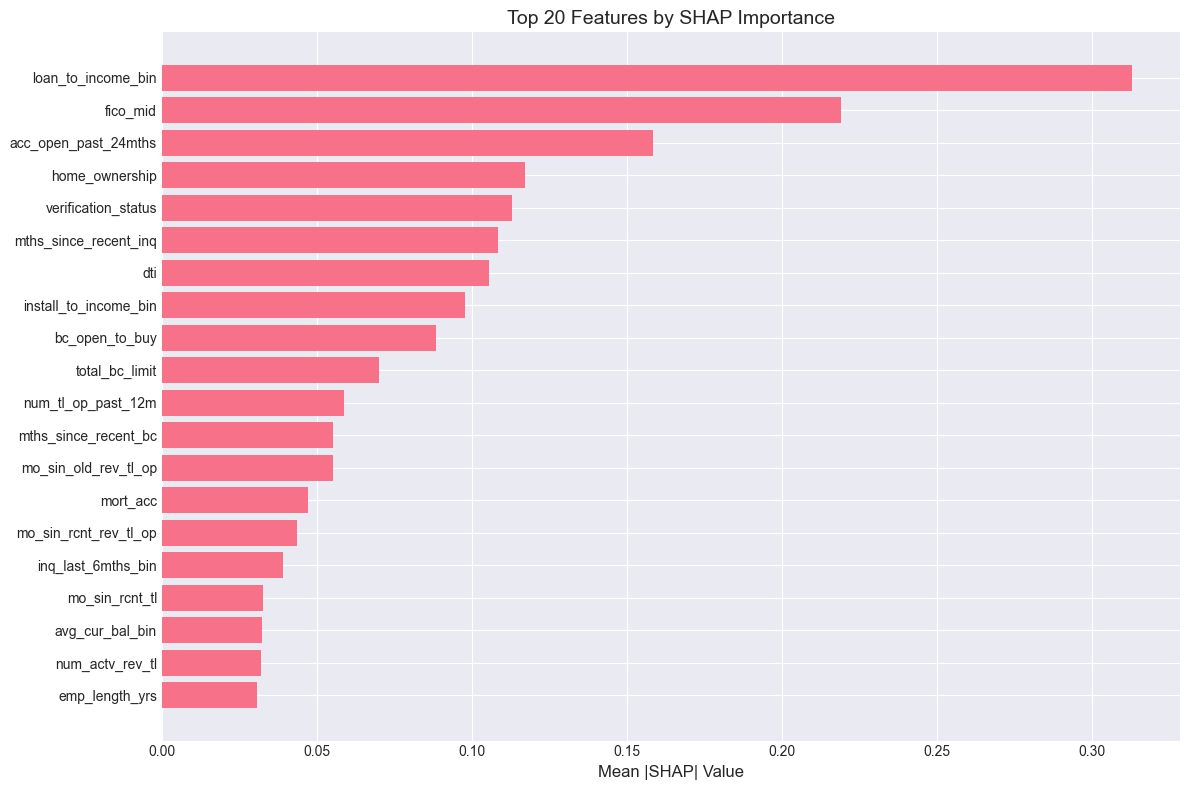


Top 10 Most Important Features:


,feature,mean_abs_shap
9,loan_to_income_bin,0.312666
5,fico_mid,0.219071
0,acc_open_past_24mths,0.158241
6,home_ownership,0.116987
20,verification_status,0.112931
15,mths_since_recent_inq,0.108485
3,dti,0.105352
8,install_to_income_bin,0.097705
2,bc_open_to_buy,0.088468
19,total_bc_limit,0.070038


In [26]:
cat_feature_set = set(cat_features)

def get_original_feature(col_name: str) -> str:
    for cat_feat in cat_feature_set:
        if col_name.startswith(f"{cat_feat}_"):
            return cat_feat
    return col_name

original_names = [get_original_feature(f) for f in feature_names]
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

shap_importance = (
    pd.DataFrame({"feature": original_names, "mean_abs_shap": mean_abs_shap})
    .groupby("feature", as_index=False)["mean_abs_shap"]
    .sum()
    .sort_values("mean_abs_shap", ascending=False)
)

plt.figure(figsize=(12, 8))
plt.barh(shap_importance["feature"].iloc[:20][::-1], shap_importance["mean_abs_shap"].iloc[:20][::-1])
plt.xlabel("Mean |SHAP| Value", fontsize=12)
plt.title("Top 20 Features by SHAP Importance", fontsize=14)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
display(shap_importance.head(10))

In [27]:
from sklearn.metrics import precision_score, recall_score

thresh = 0.10
preds = {
    "XGBoost": y_valid_pred_xgb,
    "LightGBM": y_valid_pred_lgb,
    "CatBoost": y_valid_pred_cat,
    "Logistic": y_valid_pred_lr,
}

rows = []
for name, y_score in preds.items():
    y_hat = (y_score >= thresh).astype(int)
    rows.append({
        "model": name,
        "precision": precision_score(y_valid, y_hat, zero_division=0),
        "recall": recall_score(y_valid, y_hat, zero_division=0),
    })

prec_rec_table = pd.DataFrame(rows).set_index("model").round(4)
display(prec_rec_table)

,precision,recall
model,,
XGBoost,0.1517,0.6705
LightGBM,0.1352,0.6736
CatBoost,0.1566,0.6495
Logistic,0.1433,0.6418


# 7. Business Analysis

Based on the K-S statistics, AUC and  precision/recall metrics we select the Catboost model for further business analysis. Next we analize which could be the best threshold based on expected defaulters

In [28]:
business = BusinessAnalysis()

threshold_analysis = business.analyze_thresholds(y_valid, y_valid_pred_cat)

print("Threshold Analysis (Test Set):")
display(
    threshold_analysis[
        ["threshold", "approval_rate", "default_rate_approved", "approved_defaults", "expected_loss"]
    ].head(15)
)

Threshold Analysis (Test Set):


,threshold,approval_rate,default_rate_approved,approved_defaults,expected_loss
0,0.05,0.213320,0.034632,3420,41040000.0
1,0.10,0.576878,0.061991,16555,198660000.0
2,0.15,0.822132,0.081056,30849,370188000.0
3,0.20,0.942015,0.093337,40703,488436000.0
4,0.25,0.982092,0.098560,44809,537708000.0
5,0.30,0.992843,0.100391,46141,553692000.0
6,0.35,0.998723,0.101657,47000,564000000.0
7,0.40,0.999864,0.101956,47192,566304000.0
8,0.45,0.999864,0.101956,47192,566304000.0
9,0.50,0.999864,0.101956,47192,566304000.0


## 8. Save Model Artifacts

In [29]:
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

xgb_model.save_model(str(output_dir / "xgboost_model.json"))
lgb_model.save_model(str(output_dir / "lightgbm_model.txt"))
cat_model.save_model(str(output_dir / "catboost_model.cbm"))

joblib.dump(preprocessor, output_dir / "preprocessor.pkl")
joblib.dump(calibrator, output_dir / "calibrator_xgb.pkl")
joblib.dump(calibrator_lgb, output_dir / "calibrator_lgb.pkl")
joblib.dump(calibrator_cat, output_dir / "calibrator_cat.pkl")
joblib.dump(lr_model, output_dir / "logistic_regression.pkl")
joblib.dump(calibrator_lr, output_dir / "calibrator_lr.pkl")

with open(output_dir / "feature_list.txt", "w") as f:
    f.write("\n".join(FINAL_FEATURE_SET))

threshold_analysis.to_csv(output_dir / "threshold_analysis.csv", index=False)
shap_importance.to_csv(output_dir / "shap_importance.csv", index=False)
ks_summary.to_csv(output_dir / "ks_analysis_validation.csv", index=False)

print("\nModel artifacts saved to outputs/:")
print("  - xgboost_model.json")
print("  - lightgbm_model.txt")
print("  - catboost_model.cbm")
print("  - logistic_regression.pkl")
print("  - preprocessor.pkl")
print("  - calibrator_xgb.pkl")
print("  - calibrator_lgb.pkl")
print("  - calibrator_cat.pkl")
print("  - calibrator_lr.pkl")
print("  - feature_list.txt")
print("  - threshold_analysis.csv")
print("  - segment_analysis.csv")
print("  - shap_importance.csv")
print("  - ks_analysis_validation.csv")


Model artifacts saved to outputs/:
  - xgboost_model.json
  - lightgbm_model.txt
  - catboost_model.cbm
  - logistic_regression.pkl
  - preprocessor.pkl
  - calibrator_xgb.pkl
  - calibrator_lgb.pkl
  - calibrator_cat.pkl
  - calibrator_lr.pkl
  - feature_list.txt
  - threshold_analysis.csv
  - segment_analysis.csv
  - shap_importance.csv
  - ks_analysis_validation.csv
